In [ ]:
print("hello 2")

In [2]:
from chembl_webresource_client.new_client import new_client
import pandas as pd
import re
from tqdm import tqdm

/Users/jerlynlim/Documents/mscphm/sem2/5013/project/env_1/lib/python3.10/site-packages/chembl_webresource_client/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __version__ = __import__('pkg_resources').get_distribution('chembl_webresource_client').version


In [3]:
#connecting to chemBL
activity = new_client.activity
assay = new_client.assay
molecule = new_client.molecule
target = new_client.target

In [4]:
kras_targets = target.filter(
    target_synonym__icontains="KRAS",
    target_type="SINGLE PROTEIN",
    organism="Homo sapiens"
)

kras_target_ids = [
    t["target_chembl_id"]
    for t in kras_targets
]

print(f"Found {len(kras_target_ids)} KRAS targets")

Found 1 KRAS targets


In [5]:
# Convert to DataFrame for inspection
df_targets = pd.DataFrame([
    {
        "target_chembl_id": t["target_chembl_id"],
        "pref_name": t["pref_name"],
        "organism": t["organism"],
        "target_type": t["target_type"],
        "uniprot_accessions": t.get("target_components", [{}])[0].get("accession")
    }
    for t in kras_targets
])

df_targets.head()

,target_chembl_id,pref_name,organism,target_type,uniprot_accessions
0,CHEMBL2189121,GTPase KRas,Homo sapiens,SINGLE PROTEIN,P01116


In [6]:
#filter for those targeting G12D mutation and confidence score >= 8

candidate_assays = []

for tid in kras_target_ids:
    assays = assay.filter(target_chembl_id=tid)
    for a in assays:
        desc = (a.get("description") or "").lower()
        if "g12d" in desc and a.get("confidence_score") >= 8:
            candidate_assays.append({
                "assay_chembl_id": a["assay_chembl_id"],
                "assay_type": a.get("assay_type"),
                "description": a.get("description")
            })

print(f"Candidate SII-P G12D assays: {len(candidate_assays)}")

Candidate SII-P G12D assays: 85


In [7]:
# Convert to DataFrame for inspection
df_assays = pd.DataFrame([
    {
        "assay_chembl_id": c["assay_chembl_id"],
        "assay_type": c["assay_type"],
        "description": c["description"]
    }
    for c in candidate_assays
])

df_assays.head()

,assay_chembl_id,assay_type,description
0,CHEMBL2089529,B,Binding affinity to K-Ras G12D mutant-GDP complex
1,CHEMBL2399317,B,Binding affinity to KRAS G12D mutant (unknown ...
2,CHEMBL4021570,B,Inhibition of biotinylated K-Ras G12D mutant (...
3,CHEMBL4021571,B,Inhibition of biotinylated K-Ras G12D mutant (...
4,CHEMBL4036886,B,Binding affinity to human N-terminal His/AVi-t...


In [8]:
#all assay types seem labelled as binding

assay_types = df_assays["assay_type"].unique()
print(assay_types)

['B']


In [9]:
descriptions = df_assays["description"].unique()
descriptions.shape

(83,)

In [10]:
#can we filter out cell based assays, non-allosteric site bindings and covalent inhibitors based on description?

for d in descriptions:
  print(d)

Binding affinity to K-Ras G12D mutant-GDP complex
Binding affinity to KRAS G12D mutant (unknown origin)
Inhibition of biotinylated K-Ras G12D mutant (unknown origin) assessed as reduction in SOS1 (564 to 1049 residues)-mediated BODIPY-GDP-GTP exchange after 1 hr by TR-FRET assay
Inhibition of biotinylated K-Ras G12D mutant (unknown origin) assessed as reduction in SOS1 (564 to 1049 residues)-mediated BODIPY-GDP-GTP exchange after 1 hr in presence of DTT by TR-FRET assay
Binding affinity to human N-terminal His/AVi-tagged biotinylated GTPase KRas G12D mutant (1 to 169 residues) expressed in Escherichia coli BL21 (DE3) in presence of GDP by SPR assay
Binding affinity to human N-terminal His/AVi-tagged biotinylated GTPase KRas G12D mutant (1 to 169 residues) expressed in Escherichia coli BL21 (DE3) in presence of GTP by SPR assay
Binding affinity to human N-terminal His/AVi-tagged biotinylated GTPase KRas G12D mutant (1 to 169 residues) expressed in Escherichia coli BL21 (DE3) assessed as

In [11]:
activities_query = activity.filter(
    assay_chembl_id__in=df_assays["assay_chembl_id"].unique().tolist()
  ).only(
    'molecule_chembl_id',
    'target_chembl_id',
    'standard_type',
    'standard_value',
    'standard_units',
    'standard_relation',
    'assay_type',
    'confidence_score',
    'canonical_smiles',
    'data_validity_comment'
  )

In [12]:
total_count = len(activities_query)
print(f'Total records found on server: {total_count}')

activity_list = []
for act in tqdm(activities_query, total=total_count, desc="Fetching ChEMBL Data"):
  activity_list.append(act)

df_activities = pd.DataFrame(activity_list)
csv_filename = "KRAS_G12D_chemBL_raw.csv"
df_activities.to_csv(csv_filename, index=False)
print(f'\nDownload complete!')
print(f'Total records saved: {len(df_activities)}')
if not df_activities.empty:
  print(f'Types of measurements found: {df_activities["standard_type"].unique()}')

Total records found on server: 10367


Fetching ChEMBL Data: 100%|██████████| 10367/10367 [08:25<00:00, 20.53it/s]


Download complete!
Total records saved: 10367
Types of measurements found: ['Kd' 'Activity' 'IC50' 'T1/2' 'K' 'Delta Tm' 'Inhibition' 'deltaH'
 'deltaG' '-TdeltaS' 'Tm' 'kon' 'k_off']


In [30]:
df_activities[['standard_type', 'standard_units']].value_counts()

standard_type  standard_units
IC50           nM                3429
k_off          s-1               3324
Kd             nM                 189
Tm             degrees C           13
Activity       %                   10
K              10^-4/s              9
Inhibition     %                    7
K              10^5/Ms              5
               10^6/Ms              4
Delta Tm       degrees C            4
T1/2           hr                   2
K              10'6/M/s             2
Activity       uM                   2
K              10'-2/s              2
-TdeltaS       kcal/mol             1
Activity       mM                   1
deltaG         kcal/mol             1
deltaH         kcal/mol             1
Name: count, dtype: int64

In [31]:
df_activities[['type', 'units']].value_counts()

type      units    
IC50      nM           3350
koff      s-1          3324
kon       M-1-s-1      3324
Kd        nM            173
IC50      uM             79
Kd        uM             14
Tm        degrees C      13
Activity  %              10
K         10^-4/s         9
          10^5/Ms         5
deltaTm   degrees C       4
K         10^6/Ms         4
Activity  uM              2
Kd        mM              2
t1/2      s               2
K         10'-2/s         2
          10'6/M/s        2
-TdeltaS  kcal/mol        1
Activity  mM              1
INH       %               1
deltaH    kcal/mol        1
deltaG    kcal/mol        1
Name: count, dtype: int64

In [40]:
#need to further filter the list of actives here

accepted_types = ["Kd", "IC50"]
df_filtered = df_activities[df_activities["standard_value"].notna() & (df_activities["relation"] == "=") & df_activities["standard_type"].isin(accepted_types)]
df_filtered['standard_value'] = pd.to_numeric(df_filtered['standard_value'], errors='coerce')  # non-numeric -> NaN
df_filtered = df_filtered[df_filtered['standard_value'].notna()]  # keep only rows where conversion succeeded

/var/folders/pw/3sg0trmd0q5fjprkktw_29y00000gn/T/ipykernel_21264/1438877789.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['standard_value'] = pd.to_numeric(df_filtered['standard_value'], errors='coerce')  # non-numeric -> NaN


In [41]:
#number of known actives in file

print(df_filtered["molecule_chembl_id"].nunique())

1272


In [42]:
#only IC50 for plots, scale is nM

df_IC50_nM = df_filtered[df_filtered["standard_type"] == "IC50"]
print(df_IC50_nM["molecule_chembl_id"].nunique())

1238


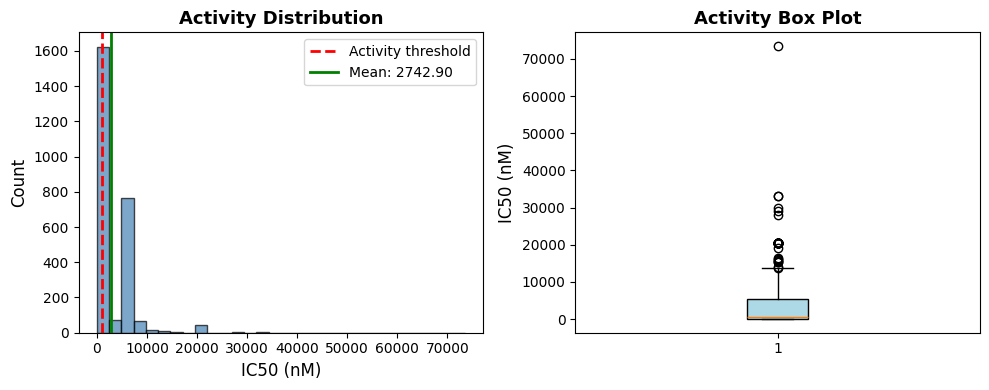

In [48]:
# ============================================================
# ACTIVITY DISTRIBUTION VISUALIZATION
# ============================================================

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Histogram
ax1 = axes[0]
ax1.hist(df_IC50_nM["standard_value"], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(x=1000.0, color='red', linestyle='--', linewidth=2, label='Activity threshold')
ax1.axvline(x=df_IC50_nM["standard_value"].mean(), color='green', linestyle='-', linewidth=2, label=f'Mean: {df_IC50_nM["standard_value"].mean():.2f}')
ax1.set_xlabel('IC50 (nM)', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Activity Distribution', fontsize=13, fontweight='bold')
ax1.legend()

# Box plot
ax2 = axes[1]
bp = ax2.boxplot(df_IC50_nM["standard_value"], patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
ax2.set_ylabel('IC50 (nM)', fontsize=12)
ax2.set_title('Activity Box Plot', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('figures/activity_distribution.png', dpi=300, bbox_inches='tight')
plt.show()